# Posprocessing a run

In [2]:
# %env XLA_PYTHON_CLIENT_MEM_FRACTION=.6
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [3]:
import lenses
import jax
import numpy as np
from jax import numpy as jnp
from typing import cast
import matplotlib.pyplot as plt

from flox.util import key_chain
from flox.flow import Pipe
import equinox as eqx

from rigid_flows.flow import build_flow, RigidWithAuxiliary
from rigid_flows.data import DataWithAuxiliary
from rigid_flows.density import OpenMMDensity
from rigid_flows.specs import ExperimentSpecification
from rigid_flows.utils import scanned_vmap

chain = key_chain(42)

2023-05-30 12:04:54.519186: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
#set bigger font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16

plt.rc('font', size=SMALL_SIZE)        # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)   # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)   # fontsize of the figure title

In [5]:
def count_params(model):
    return jax.tree_util.tree_reduce(
        lambda s, n: s + n.size if eqx.is_array(n) else s, model, jnp.zeros((), dtype=jnp.int32)).item()

def ess(logw):
    return jnp.exp(2*jax.scipy.special.logsumexp(logw)-jax.scipy.special.logsumexp(2*logw))

In [6]:
import glob
logdir_path = "../experiments/ice_N16_T100"

dirs = glob.glob(f'{logdir_path}/training_stage_*')
stage = max([int(d.split("_")[-1]) for d in dirs])
dirs = glob.glob(f'{logdir_path}/training_stage_{stage}/epoch_*')
epoch = max([int(d.split("_")[-1]) for d in dirs])
print(f"+++ trainng stage {stage}, epoch {epoch} +++")
specs_path = f"{logdir_path}/config.yaml"
pretrained_model_path = f"{logdir_path}/training_stage_{stage}/epoch_{epoch}/model.eqx"
print(pretrained_model_path)

+++ trainng stage 0, epoch 9 +++
../experiments/ice_N16_T100/training_stage_0/epoch_9/model.eqx


In [7]:
specs = ExperimentSpecification.load_from_file(specs_path)
# eval_path = specs.model.base.path + "/eval"
# specs = lenses.bind(specs).model.base.path.set(eval_path)
# specs = lenses.bind(specs).model.target.path.set(eval_path)
if specs.model.target.num_samples == 0:
    specs = lenses.bind(specs).model.target.num_samples.set(100_000)

base = OpenMMDensity.from_specs(specs.model.use_auxiliary, specs.model.base)
model = base.omm_model.model

print(f"MD training datapoints = {specs.model.base.num_samples:_}")
print(f"MD eval datapoints = {base.data.pos.shape[0]:_}")
print(f"batchs per epoch = {specs.train[0].num_iters_per_epoch}")
print(f"batch size = {specs.train[0].num_samples}")
print(f"data fraction: {specs.train[0].num_epochs*specs.train[0].num_samples*specs.train[0].num_iters_per_epoch/specs.model.base.num_samples}")

MD training datapoints = 10_000
MD eval datapoints = 10_000
batchs per epoch = 1000
batch size = 32
data fraction: 32.0


In [8]:
try:
    ref_file = f"../MDdata/ice/DeltaF_estimates/DF-{specs.model.base}-{specs.model.target}.txt"
    reference_deltaF, reference_deltaF_std = np.loadtxt(ref_file, unpack=True)
except FileNotFoundError:
    reference_deltaF, reference_deltaF_std = None, None

reference_deltaF, reference_deltaF_std

(-669.7109, 0.05418)

In [9]:
sc = model.n_molecules
test_subplots = False

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.image as mpimg

loss = np.loadtxt(logdir_path+'/loss.txt')
loss_info = np.stack([1+np.arange(len(loss)), loss], axis=-1)

def plot_loss():
    plt.plot(loss_info[:,0], loss_info[:,1]/sc)
    if reference_deltaF is not None:
        plt.axhline(reference_deltaF/sc, c='k', ls=':', label='$\Delta F$')
    plt.xlabel('steps')
    plt.ylabel('loss')
    plt.xlim(1e2, loss_info[-1,0])
    plt.legend(loc='upper left')
    # plt.xscale('log')
    # plt.xlim(0, loss_info[-1,0])
    # plt.legend(loc='lower left')

    img = mpimg.imread(f'../MDdata/ice/iceXI-N{model.n_molecules}.png')
    subax = inset_axes(plt.gca(), width="50%", height="60%", loc=1)
    subax.imshow(img)
    subax.axis('off')
    
if test_subplots:
    plot_loss()
    plt.show()

num_samples=10_000
sample base
map base


/home/mi/minvernizzi/mambaforge/envs/flox/lib/python3.10/site-packages/equinox/nn/_normalisation.py:84: UserWarning: LayerNorm(elementwise_affine=...) is deprecated in favour of LayerNorm(use_weight=...) and LayerNorm(use_bias=...)
  warnings.warn(


tot flow parameters: 290_896
compute weights
sample target


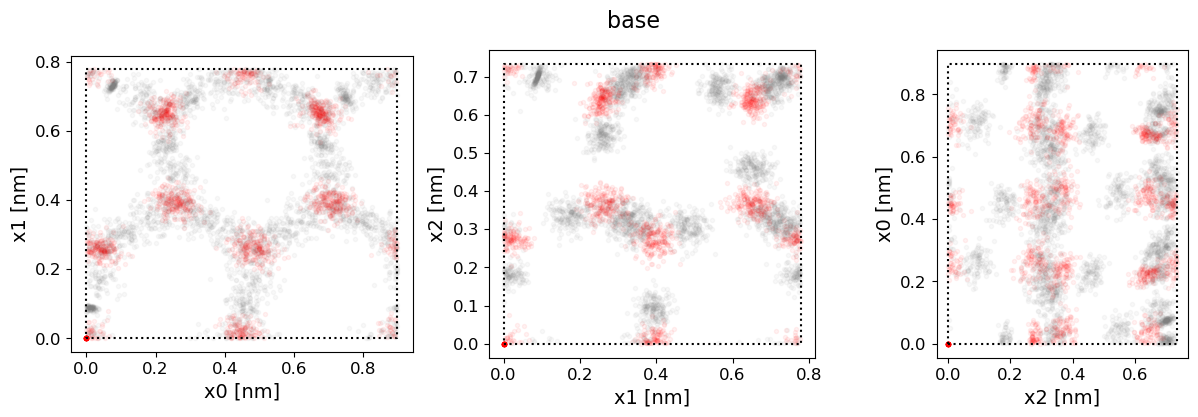

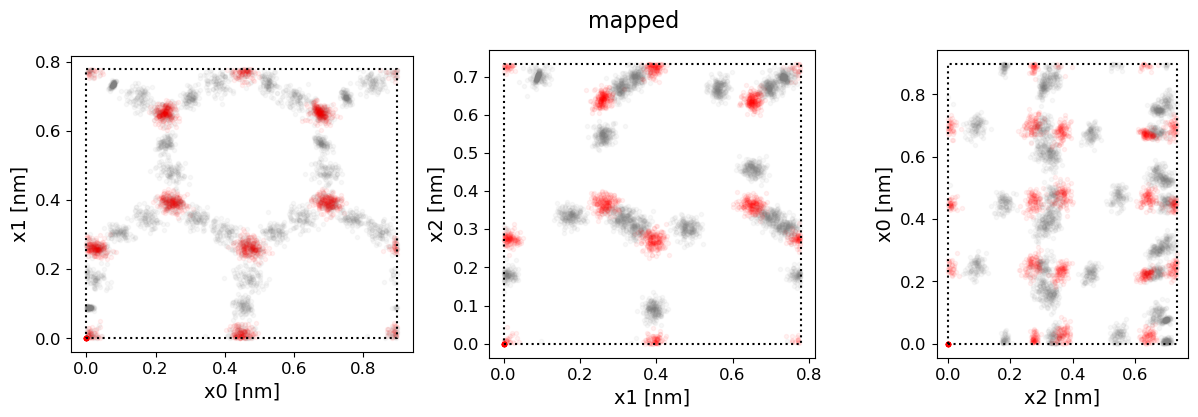

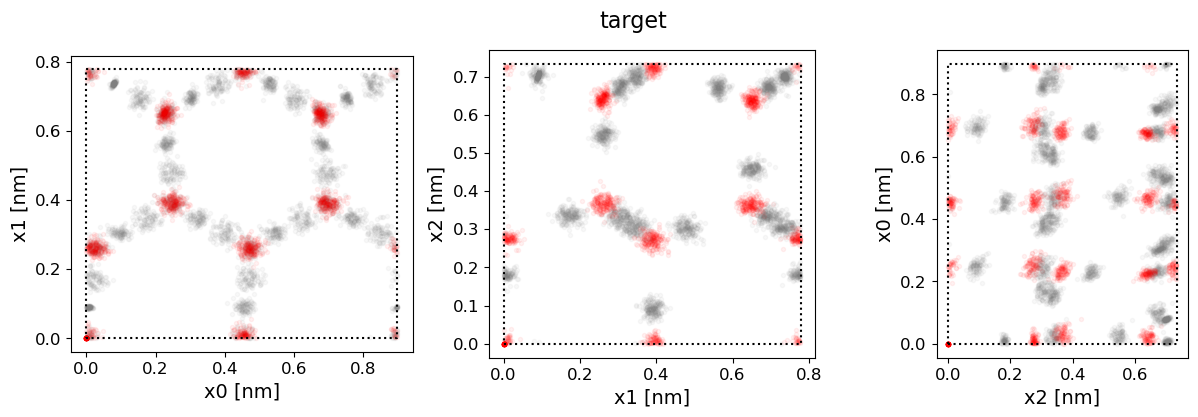

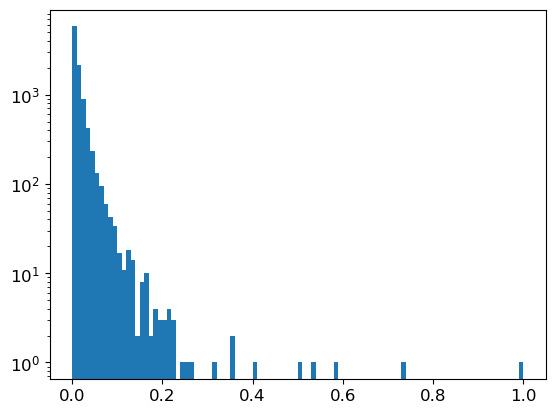

ESS = 2375.47  ->  23.75%
Estimated deltaF from LFEP = -41.8647
          Reference deltaF = -41.8569


In [11]:
recompute = False
datafilename = logdir_path+'/fig-data'

try:
    if recompute:
        raise FileNotFoundError
    data = np.load(datafilename+'.npz')
    base_pos = data['base_pos']
    base_ene = data['base_ene']
    mapped_pos = data['mapped_pos']
    mapped_ene = data['mapped_ene']
    target_pos = data['target_pos']
    target_ene = data['target_ene']
    weights = data['weights']
    print(f'ESS = {ess(np.log(weights)):g}  ->  {ess(np.log(weights))/len(weights):.2%}')
    
except FileNotFoundError:
    num_samples = base.data.pos.shape[0]
    print(f'num_samples={num_samples:_}')
    def jitvmap(fn, batch_size=512):
        if batch_size is None:
            return jax.jit(jax.vmap(fn))
        else:
            return jax.jit(scanned_vmap(fn, batch_size))

    print('sample base')
    keys = jax.random.split(next(chain), num_samples)
    base_tr = jitvmap(base.sample_idx)(keys, jnp.arange(num_samples))
    base_pos = np.array(base_tr.obj.pos.reshape(-1, model.n_atoms, 3))
    base_ene = np.array(base_tr.ldj * base.omm_model.kbT)

    print('map base')
    flow = build_flow(
        next(chain),
        specs.model.base.num_molecules,
        specs.model.use_auxiliary,
        specs.model.flow,
    )
    flow = cast(
        Pipe[DataWithAuxiliary, RigidWithAuxiliary],
        eqx.tree_deserialise_leaves(pretrained_model_path, flow),
    )
    print(f"tot flow parameters: {count_params(flow):_}")
    mapped_tr = jitvmap(flow.forward)(base_tr.obj)
    mapped_pos = np.array(mapped_tr.obj.pos.reshape(-1, model.n_atoms, 3))

    print('compute weights')
    target = OpenMMDensity.from_specs(specs.model.use_auxiliary, specs.model.target)
    ## NB: base_tr.ldj = jax.vmap(base.potential)(base_tr.obj)
    mapped_ene_tg = jitvmap(target.potential)(mapped_tr.obj)
    mapped_ene = np.array(mapped_ene_tg * target.omm_model.kbT)

    logw = base_tr.ldj + mapped_tr.ldj - mapped_ene_tg
    weights = np.array(jnp.exp(logw-jax.scipy.special.logsumexp(logw)))

    print('sample target')
    keys = jax.random.split(next(chain), num_samples)
    target_tr = jitvmap(target.sample_idx)(keys, jnp.arange(num_samples))
    target_pos = np.array(target_tr.obj.pos.reshape(-1, model.n_atoms, 3))
    target_ene = np.array(target_tr.ldj * target.omm_model.kbT)

    def plot_2Dview(data_tr: DataWithAuxiliary, title: str, toPBC: bool = True, skip: int = 100):
        model.plot_2Dview(data_tr.obj.pos.reshape(-1, model.n_atoms, 3)[::skip], toPBC=toPBC, title=title)

    plot_2Dview(base_tr, title='base')
    plot_2Dview(mapped_tr, title='mapped')
    plot_2Dview(target_tr, title='target')

    plt.hist(jnp.exp(logw - logw.max()), bins=100)
    plt.yscale('log')
    plt.show()
    print(f'ESS = {ess(logw):g}  ->  {ess(logw)/len(logw):.2%}')

    ## TFEP
    deltaF = (jnp.log(len(logw)) - jax.scipy.special.logsumexp(logw)).item()
    print(f'Estimated deltaF from LFEP = {deltaF/sc:g}')
    if reference_deltaF is not None:
        print(f'          Reference deltaF = {reference_deltaF/sc:g}')

In [12]:
bins = np.linspace(-20.5, -17.5, 100)*model.n_molecules*3/sc
hist_kwargs = {"bins": bins, "density": True, "alpha": 0.5}

def plot_energy():
    plt.hist(base_ene/sc, **hist_kwargs, label='base')
    plt.hist(mapped_ene/sc, **hist_kwargs, label='mapped')
    plt.hist(target_ene/sc, **hist_kwargs, label='target')
    if model.n_molecules == 128: #ESS is small, histogram resolution must be smaller
        mybins = 75
    else:
        mybins = hist_kwargs['bins']
    plt.hist(mapped_ene/sc, weights=weights, label='reweighted', bins=mybins, density=True, histtype='step')
    plt.xlabel('potential energy / N [kJ/mol]')
    plt.xlim(bins[0], bins[-1])
    plt.ylabel('density')
    plt.legend()

if test_subplots:
    plot_energy()
    plt.show()

In [13]:
import mdtraj as md

n_bins = 200
r_range = [0.2, 0.7]
ij = model.mdtraj_topology.select_pairs("name == O", "name == O")

base_rdf = md.compute_rdf(model.get_mdtraj(base_pos), ij, r_range=r_range, n_bins=n_bins)
mapped_rdf = md.compute_rdf(model.get_mdtraj(mapped_pos), ij, r_range=r_range, n_bins=n_bins)
target_rdf = md.compute_rdf(model.get_mdtraj(target_pos), ij, r_range=r_range, n_bins=n_bins)

In [14]:
#notice that rdf is very good even without reweighting

def plot_rdf():
    plt.plot(*base_rdf, label='base', lw=2)
    plt.plot(*mapped_rdf, label='mapped', lw=4, ls='--')
    plt.plot(*target_rdf, label='target', lw=2)
    plt.ylabel("g(r)")
    plt.xlabel("r [nm]")
    plt.xlim(r_range)
    plt.yticks(np.arange(0, 14, 2))
    plt.ylim(None, 13)
    plt.ylabel("oxygen g(r)")
    plt.legend()

if test_subplots:
    plot_rdf()
    plt.show()

## create the figure

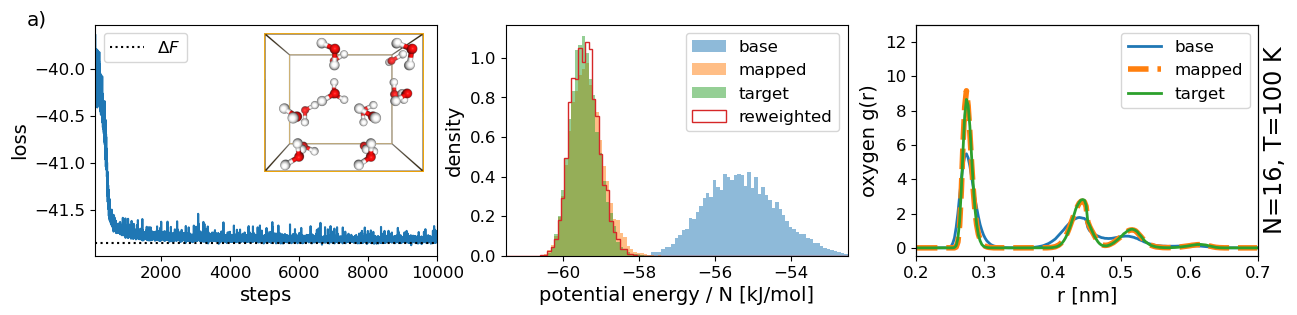

In [15]:
save_figure = True

match f"N{model.n_molecules}_T{specs.model.target.temperature}":
    case "N16_T100":
        label_txt = "a)"
    case "N16_T50":
        label_txt = "b)"
    case "N128_T100":
        label_txt = "c)"
    case _:
        label_txt = "d)"

plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plt.text(-0.2, 1.0, label_txt, transform=plt.gca().transAxes, fontdict={'fontsize': 'large'})
plot_loss()

plt.subplot(1, 3, 2)
plot_energy()

plt.subplot(1, 3, 3)
plot_rdf()
ax = plt.gca().twinx()
ax.set_ylabel(f"N={model.n_molecules}, T={specs.model.target.temperature} K", fontsize="x-large")
ax.set_yticks([])

filename = f"ice_results-N{model.n_molecules}_T{specs.model.target.temperature}.pdf"
if save_figure:
    plt.savefig(filename, bbox_inches="tight")
plt.show()

In [16]:
save_data = False

## backup and save figure
!bck.meup.sh {logdir_path}/{filename}
!cp {filename} {logdir_path}/{filename}

## store all useful data
if save_data:
    np.savez(
        datafilename, 
        base_ene=base_ene, 
        mapped_ene=mapped_ene, 
        target_ene=target_ene, 
        weights=weights, 
        base_pos=base_pos, 
        mapped_pos=mapped_pos, 
        target_pos=target_pos
    )

## configurations

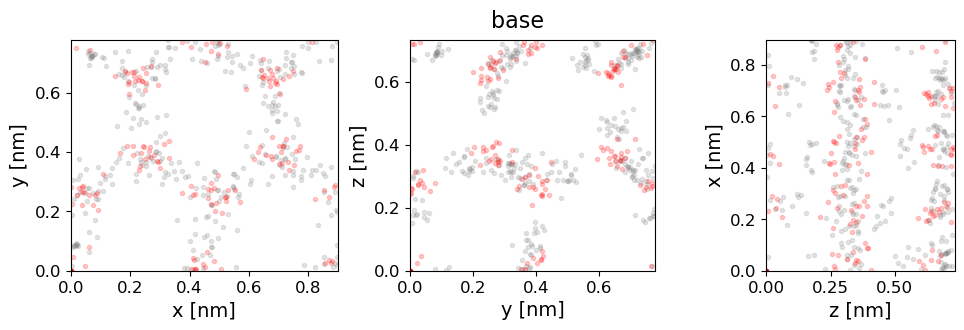

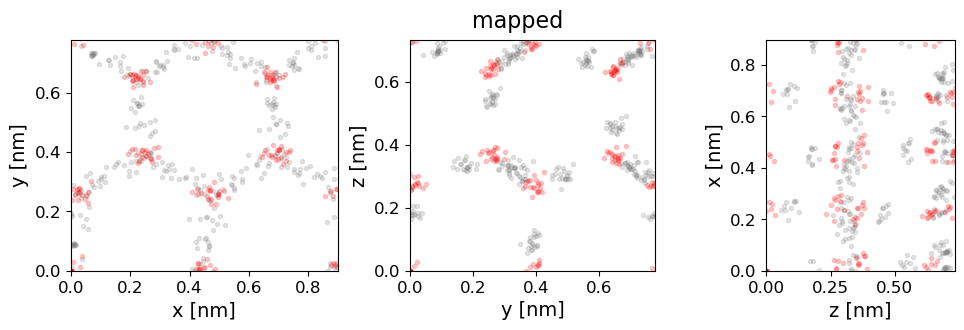

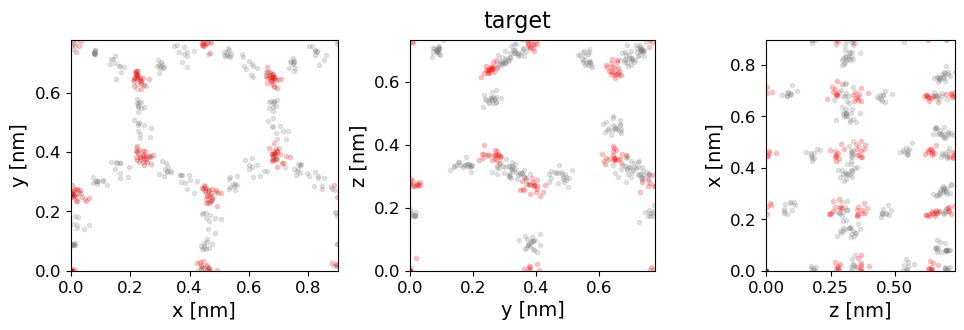

In [17]:
save_figure = False

def plot_proj(pos, title='', marker='.', alpha=0.2, av_box=model.box):
    mypos = pos % np.diagonal(av_box)
    plt.figure(figsize=(12, 3))
    plt.suptitle(title)
    for i in range(3):
        ii = (i + 1) % 3
        iii = (i + 2) % 3
        plt.subplot(1, 3, 1 + i)

        # draw particles
        plt.scatter(
            mypos[..., 1 :: model.n_sites, i],
            mypos[..., 1 :: model.n_sites, ii],
            marker=marker,
            alpha=alpha,
            c="gray",
            rasterized=True
        )
        plt.scatter(
            mypos[..., 2 :: model.n_sites, i],
            mypos[..., 2 :: model.n_sites, ii],
            marker=marker,
            alpha=alpha,
            c="gray",
            rasterized=True
        )
        plt.scatter(
            mypos[..., :: model.n_sites, i],
            mypos[..., :: model.n_sites, ii],
            marker=marker,
            alpha=alpha,
            c="r",
            rasterized=True
        )

        def get_label(j):
            match j:
                case 0: 
                    return 'x'
                case 1:
                    return 'y'
                case 2:
                    return 'z'

        plt.xlabel(f"{get_label(i)} [nm]")
        plt.ylabel(f"{get_label(ii)} [nm]")
        plt.xlim(0, av_box[i,i])
        plt.ylim(0, av_box[ii,ii])
        plt.gca().set_aspect(1)
    # plt.show()

plot_proj(base_pos[::1000], 'base')
if save_figure:
    plt.savefig('ice_config-base.pdf', bbox_inches='tight')
plt.show()
plot_proj(mapped_pos[::1000], 'mapped')
if save_figure:
    plt.savefig('ice_config-mapped.pdf', bbox_inches='tight')
plt.show()
plot_proj(target_pos[::1000], 'target')
if save_figure:
    plt.savefig('ice_config-target.pdf', bbox_inches='tight')
plt.show()